In [1]:
# import yfinance to get historical data
import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "data/msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [3]:
# testing how yf works
'''
msft = yf.Ticker("MSFT")
msft = msft.history(period="max")
msft
'''

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055949,0.064177,0.055949,0.061434,1031788800,0.0,0.0
1986-03-14,0.061434,0.064725,0.061434,0.063628,308160000,0.0,0.0
1986-03-17,0.063628,0.065274,0.063628,0.064725,133171200,0.0,0.0
1986-03-18,0.064725,0.065274,0.062531,0.063079,67766400,0.0,0.0
1986-03-19,0.063079,0.063628,0.061434,0.061982,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2022-03-17,293.290009,295.609985,289.369995,295.220001,30816600,0.0,0.0
2022-03-18,295.369995,301.000000,292.730011,300.429993,43317000,0.0,0.0
2022-03-21,298.890015,300.140015,294.899994,299.160004,28351200,0.0,0.0


In [2]:
# sequential time series data
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055949,0.064177,0.055949,0.061434,1031788800,0.0,0.0
1986-03-14,0.061434,0.064725,0.061434,0.063628,308160000,0.0,0.0
1986-03-17,0.063628,0.065274,0.063628,0.064725,133171200,0.0,0.0
1986-03-18,0.064725,0.065274,0.062531,0.063079,67766400,0.0,0.0
1986-03-19,0.063079,0.063628,0.061434,0.061982,47894400,0.0,0.0


<AxesSubplot:>

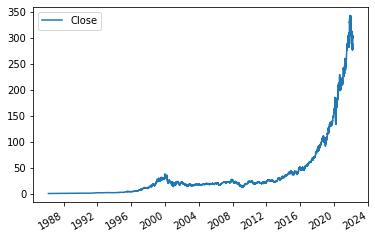

In [3]:
msft_hist.plot.line(y="Close", use_index=True)

In [4]:
# setting up a target
# this is essentially what we are going to be trying to predict

# getting the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns={"Close": "Actual_Close"})

# this is the process of setting up the target - seeing if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [5]:
data.head()

,Actual_Close,Target
1986-03-13,0.061434,NaN
1986-03-14,0.063628,1.0
1986-03-17,0.064725,1.0
1986-03-18,0.063079,0.0
1986-03-19,0.061982,0.0


In [6]:
# shift the stock prices forward one day, so we are predicting tomorrow's stock price from today's prices
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [7]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055949,0.064177,0.055949,0.061434,1.031789e+09,0.0,0.0
1986-03-17,0.061434,0.064725,0.061434,0.063628,3.081600e+08,0.0,0.0
1986-03-18,0.063628,0.065274,0.063628,0.064725,1.331712e+08,0.0,0.0
1986-03-19,0.064725,0.065274,0.062531,0.063079,6.776640e+07,0.0,0.0


In [8]:
# we need to choose our predictors for the target
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14,0.063628,1.0,0.061434,1.031789e+09,0.055949,0.064177,0.055949
1986-03-17,0.064725,1.0,0.063628,3.081600e+08,0.061434,0.064725,0.061434
1986-03-18,0.063079,0.0,0.064725,1.331712e+08,0.063628,0.065274,0.063628
1986-03-19,0.061982,0.0,0.063079,6.776640e+07,0.064725,0.065274,0.062531
1986-03-20,0.060337,0.0,0.061982,4.789440e+07,0.063079,0.063628,0.061434


In [9]:
# We are going to use a model that uses decision trees from scikit leard
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# create a random forest classification model. set parameters to prevent overfitting
# min_samples_split -> to prevent overfitting
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [12]:
# training the model itself
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

# fitting the model
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [15]:
# measuring the error using precision
from sklearn.metrics import precision_score

# evaluate the error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4888888888888889

<AxesSubplot:>

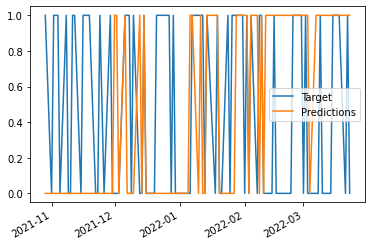

In [16]:
# comparing the Target (up or down) to the actual

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [19]:
# BACKTESTING
# We are going to be testing our data every 750 rows

# this is one iteration
i = 1000 # FIRST 1000 ROWS OR OUR DATA
step = 750 # TESTING SET

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [20]:
# we are going to make it such that the price will only go up if this majorly confident that the price will increase
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)

# this is to check how confident we are
preds[preds > .6] = 1
preds[preds <= .6] = 0

preds.head()

1990-02-27    1.0
1990-02-28    1.0
1990-03-01    1.0
1990-03-02    1.0
1990-03-05    1.0
dtype: float64

In [22]:
# turing this into a loop
predictions = []
step = 750 # TESTING SET

# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [24]:
predictions[0].head()

,Target,Predictions
1990-02-27,0.0,1.0
1990-02-28,1.0,1.0
1990-03-01,1.0,1.0
1990-03-02,1.0,1.0
1990-03-05,1.0,1.0


In [25]:
# abstracting this and turning it into a function
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [26]:
predictions = backtest(data, model, predictors)
predictions

,Target,Predictions
1990-02-27,0.0,1.0
1990-02-28,1.0,1.0
1990-03-01,1.0,1.0
1990-03-02,1.0,1.0
1990-03-05,1.0,1.0
...,...,...
2022-03-17,1.0,0.0
2022-03-18,1.0,0.0
2022-03-21,0.0,0.0
2022-03-22,1.0,0.0


In [27]:
predictions["Predictions"].value_counts()

0.0    7353
1.0     728
Name: Predictions, dtype: int64

In [28]:
predictions["Target"].value_counts()

1.0    4097
0.0    3984
Name: Target, dtype: int64

In [30]:
precision_score(predictions["Target"], predictions["Predictions"])

0.510989010989011

In [31]:
# the prediction is low because we do not have enough predictors

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]
data["weekly_trend"] = weekly_trend

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [32]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

In [33]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [34]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5721925133689839

In [35]:
predictions["Predictions"].value_counts()

0.0    7529
1.0     187
Name: Predictions, dtype: int64

<AxesSubplot:>

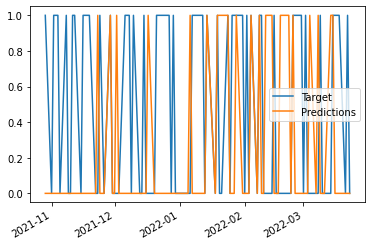

In [37]:
predictions.iloc[-100:].plot()